# Single-cell analysis and prediction of tumor-infiltrating immune cells
Author: Margaret Paiva

### Dependencies and setting

In [63]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import OrderedDict
import scintegral.classifier as scint_classifier
import scintegral.utils as scint_utils
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.6 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


### Data

In [3]:
# table with clinical responses
# complete response (CR) and partial response (PR) for responders, 
# stable disease (SD) and progressive disease (PD) for nonresponders
meta = pd.read_csv('data/GSE120575_patient_ID_single_cells.txt.gz', 
                   sep="\t", encoding="latin", 
                   skiprows=19).iloc[:, :7]
# remove additional information after sample table
meta = meta.iloc[:16291]

# rename columns by removing the `characteristics: ` prefix to make it more concise
meta.columns = [x.replace("characteristics: ", "") for x in meta.columns]

# rename the long `patient ID (...)` column to simple sample_id
meta.rename(
    columns={"patinet ID (Pre=baseline; Post= on treatment)": "sample_id"},
    inplace=True
)

# add columns that seperate sample_id for later analysis
meta["patient_id"] = [x.split("_")[1] for x in meta.sample_id]
meta["time_point"] = [x.split("_")[0] for x in meta.sample_id]

meta

Sample name                      title           source name  \
0          Sample 1                 A10_P3_M11  Melanoma single cell   
1          Sample 2                 A11_P1_M11  Melanoma single cell   
2          Sample 3                 A11_P3_M11  Melanoma single cell   
3          Sample 4                 A11_P4_M11  Melanoma single cell   
4          Sample 5                 A12_P3_M11  Melanoma single cell   
...             ...                        ...                   ...   
16286  Sample 16287  H5_P5_M67_L001_T_enriched  Melanoma single cell   
16287  Sample 16288  H6_P5_M67_L001_T_enriched  Melanoma single cell   
16288  Sample 16289  H7_P5_M67_L001_T_enriched  Melanoma single cell   
16289  Sample 16290  H8_P5_M67_L001_T_enriched  Melanoma single cell   
16290  Sample 16291  H9_P5_M67_L001_T_enriched  Melanoma single cell   

           organism sample_id       response     therapy patient_id time_point  
0      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
1      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
2      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
3      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
4      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
...             ...       ...            ...         ...        ...        ...  
16286  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16287  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16288  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16289  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16290  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  

[16291 rows x 9 columns]

In [4]:
# table with sc gene expression
# ge = pd.read_csv('data/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz', 
#                  sep="\t", skiprows=3)

adata = sc.read_text('data/GSE120575_melanoma_scrna_tpm.txt.gz').transpose()
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16291 × 55737

In [5]:
adata.obs

Empty DataFrame
Columns: []
Index: [A10_P3_M11, A11_P1_M11, A11_P3_M11, A11_P4_M11, A12_P3_M11, A12_P6_M11, A2_P1_M11, A2_P4_M11, A3_P1_M11, A3_P3_M11, A4_P3_M11, A4_P4_M11, A4_P6_M11, A5_P4_M11, A5_P5_M11, A6_P1_M11, A6_P4_M11, A6_P6_M11, A7_P2_M11, A7_P6_M11, A8_P1_M11, A8_P6_M11, A9_P1_M11, A9_P4_M11, B10_P1_M11, B10_P3_M11, B10_P4_M11, B10_P6_M11, B11_P6_M11, B12_P3_M11, B12_P4_M11, B1_P2_M11, B1_P4_M11, B2_P1_M11, B2_P5_M11, B2_P6_M11, B3_P1_M11, B3_P5_M11, B4_P1_M11, B4_P4_M11, B4_P6_M11, B5_P1_M11, B5_P6_M11, B6_P1_M11, B7_P4_M11, B8_P6_M11, B9_P2_M11, C10_P4_M11, C10_P6_M11, C11_P4_M11, C11_P6_M11, C12_P4_M11, C1_P3_M11, C1_P4_M11, C2_P6_M11, C3_P1_M11, C4_P1_M11, C4_P3_M11, C4_P4_M11, C4_P6_M11, C5_P3_M11, C5_P5_M11, C5_P6_M11, C6_P2_M11, C6_P3_M11, C6_P4_M11, C7_P3_M11, C7_P5_M11, C7_P6_M11, C8_P3_M11, C8_P5_M11, C9_P1_M11, C9_P2_M11, C9_P4_M11, D10_P1_M11, D10_P6_M11, D11_P6_M11, D12_P6_M11, D1_P1_M11, D1_P4_M11, D1_P6_M11, D2_P4_M11, D2_P6_M11, D3_P1_M11, D3_P3_M11, D3_P6_M11, D4_P1_M11, D4_P3_M11, D4_P4_M11, D4_P6_M11, D5_P4_M11, D5_P5_M11, D5_P6_M11, D6_P1_M11, D6_P3_M11, D6_P5_M11, D6_P6_M11, D7_P3_M11, D7_P5_M11, D8_P2_M11, ...]

[16291 rows x 0 columns]

In [6]:
adata.var

Empty DataFrame
Columns: []
Index: [TSPAN6, TNMD, DPM1, SCYL3, C1orf112, FGR, CFH, FUCA2, GCLC, NFYA, STPG1, NIPAL3, LAS1L, ENPP4, SEMA3F, CFTR, ANKIB1, CYP51A1, KRIT1, RAD52, MYH16, BAD, LAP3, CD99, HS3ST1, AOC1, WNT16, HECW1, MAD1L1, LASP1, SNX11, TMEM176A, M6PR, KLHL13, CYP26B1, ICA1, DBNDD1, ALS2, CASP10, CFLAR, TFPI, NDUFAF7, RBM5, MTMR7, SLC7A2, ARF5, SARM1, POLDIP2, PLXND1, AK2, CD38, FKBP4, KDM1A, RBM6, CAMKK1, RECQL, CCDC132, HSPB6, ARHGAP33, NDUFAB1, PDK4, SLC22A16, ZMYND10, ABCB5, ARX, SLC25A13, ST7, CDC27, SLC4A1, CALCR, HCCS, DVL2, PRSS22, UPF1, SKAP2, SLC25A5, CCDC109B, HOXA11, POLR2J, DHX33, MEOX1, THSD7A, LIG3, RPAP3, ACSM3, AC004381.6, CIAPIN1, SPPL2B, FAM214B, COPZ2, PRKAR2B, MSL3, CREBBP, BZRAP1, MPO, PON1, GCFC2, WDR54, CROT, ABCB4, ...]

[55737 rows x 0 columns]

In [7]:
adata.X[0:5, 0:10]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 9.24, 0.  , 0.  , 0.  , 0.  , 0.  , 1.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 7.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [8]:
adata.X.shape

(16291, 55737)

In [9]:
adata.obs = adata.obs.merge(meta, 
                            left_index=True, 
                            right_on='title').set_index('title')
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  
title                                 
A10_P3_M11                       Pre  
A11_P1_M11                       Pre  
A11_P3_M11                       Pre  
A11_P4_M11                       Pre  
A12_P3_M11                       Pre  
...                              ...  
H5_P5_M67_L001_T_enriched       Post  
H6_P5_M67_L001_T_enriched       Post  
H7_P5_M67_L001_T_enriched       Post  
H8_P5_M67_L001_T_enriched       Post  
H9_P5_M67_L001_T_enriched       Post  

[16291 rows x 8 columns]

In [10]:
# Get the statistics of the data
# These TPM values; no logarithmizing
mean_expr = pd.Series(adata.X.mean(axis=0))
mean_expr.index = adata.var.index
mean_expr.describe()

count    55737.000000
mean         0.275007
std          0.842511
min          0.000000
25%          0.001366
50%          0.007080
75%          0.105477
max         16.430943
dtype: float64

### Preprocessing

Basic filter:

In [11]:
# Each cell should have a minimum genes expressed;
# Otherwise, they are dropouts
sc.pp.filter_cells(adata, min_genes=200)
# Each genes should be expressed in at least a certain number of cells
# to be considered as an expressed gene
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes'
    var: 'n_cells'

Find and filter genes that are potentially noisy: 

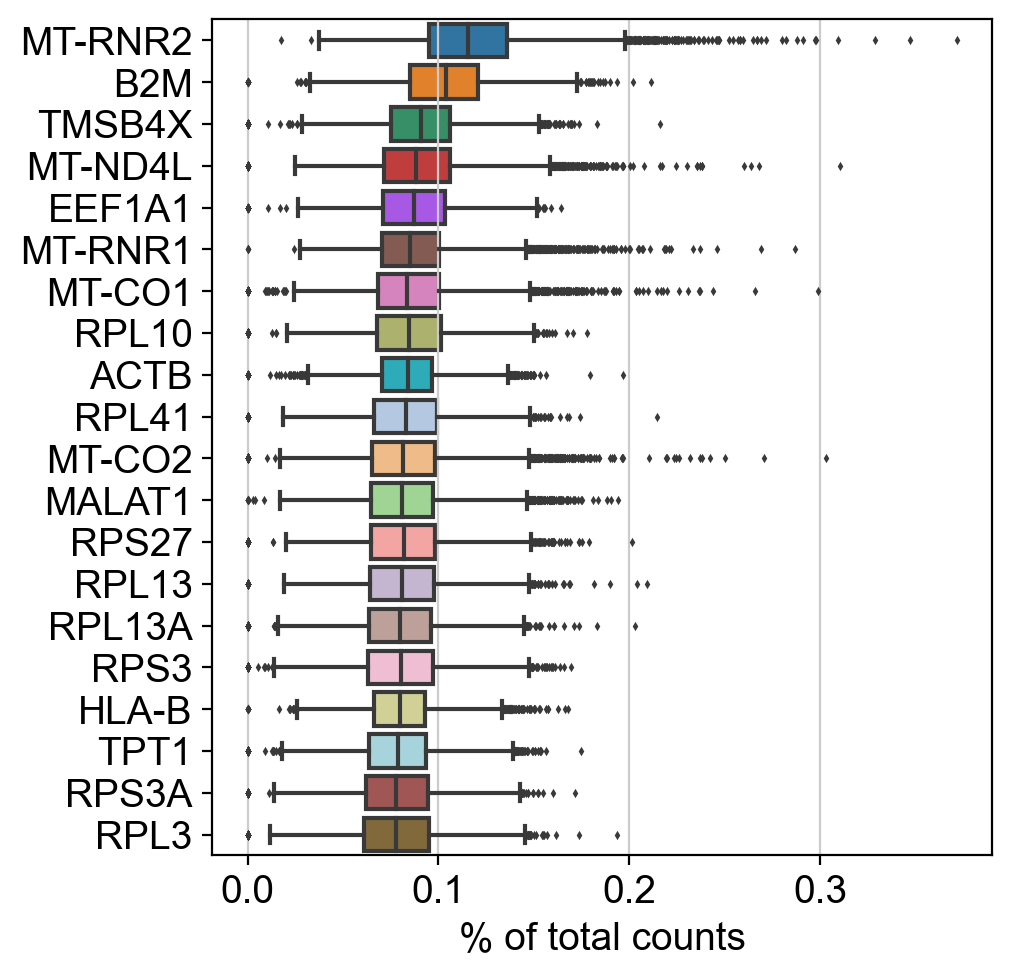

In [12]:
# First, plot genes that yield the highest fraction of counts in each single cell, 
# across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [13]:
# High proportions of mitochondrial genes are indicative of poor-quality cells
# possibly because of loss of cytoplasmic RNA from perforated cells

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'source name' as categorical
/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'organism' as categorical
/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories i

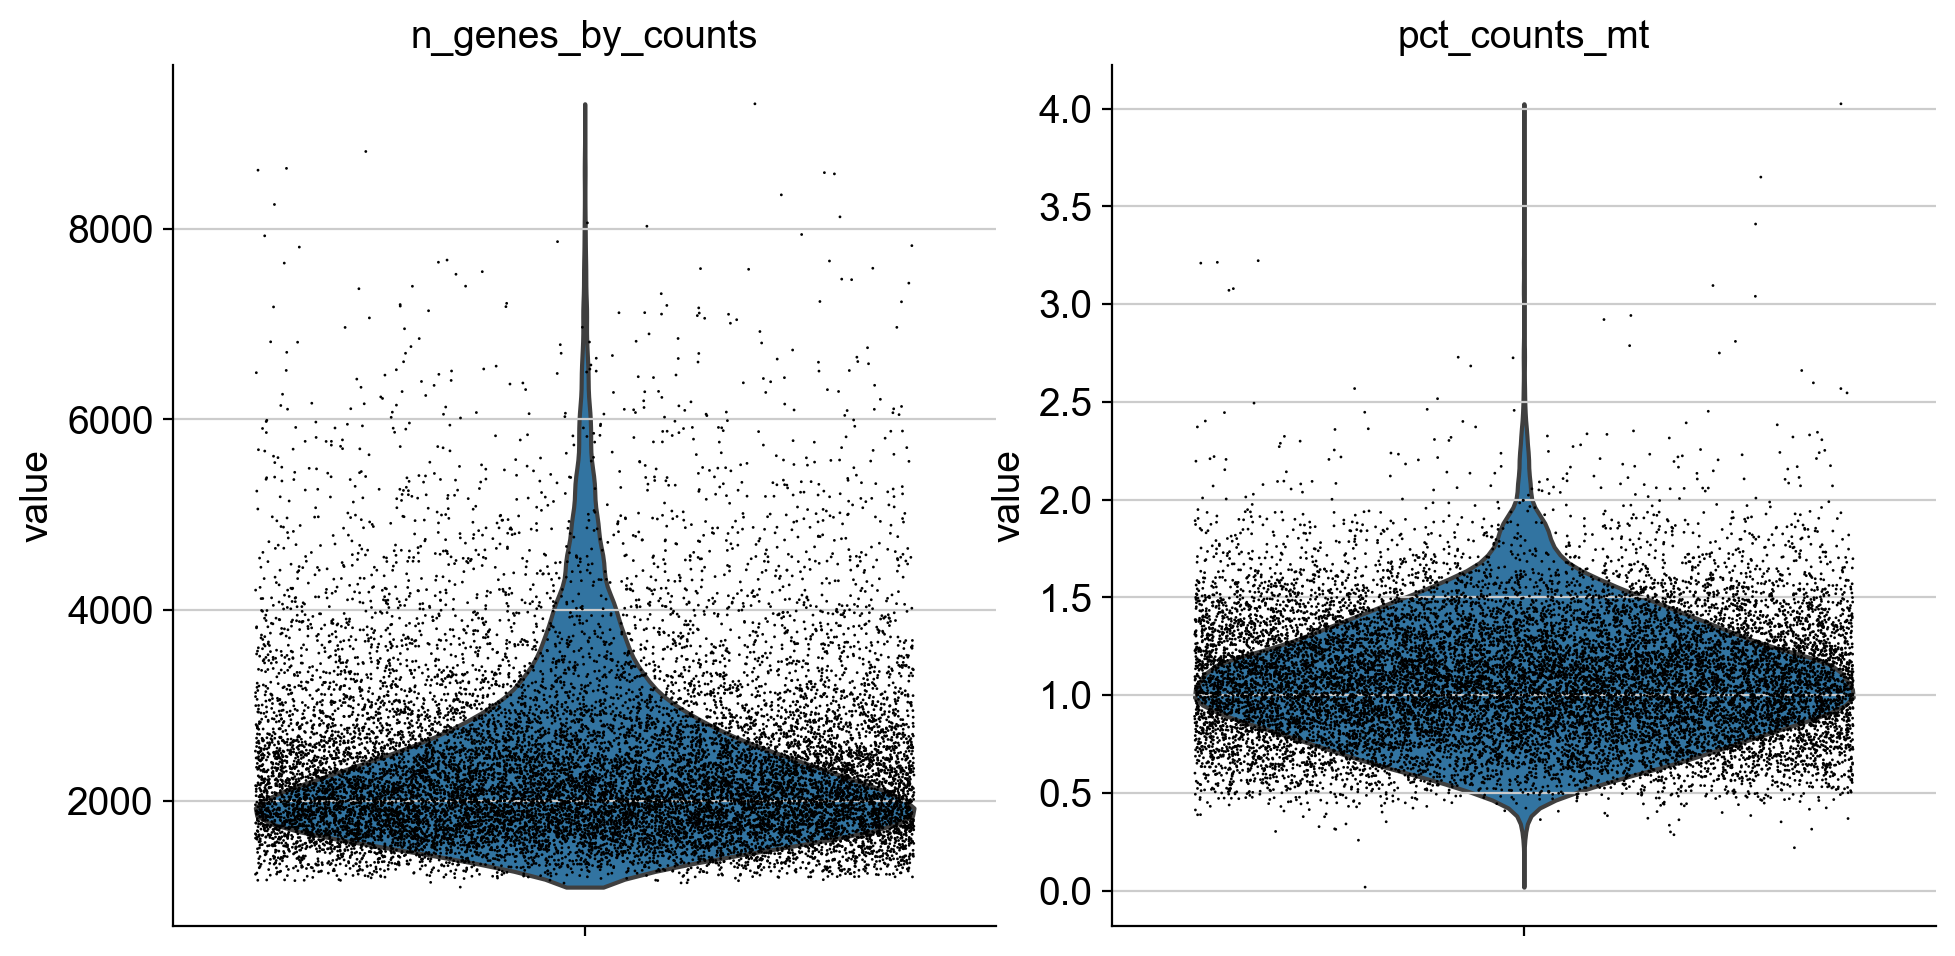

In [14]:
# "n_genes_by_counts" is the genes with various counts expressed in one cell
# too many counts means that that gene could be a noisy geneb 
sc.pl.violin(adata, ['n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
# filtering noisy genes (samples with too many genes expressed)
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
# filtering samples with too many mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 2.5, :]
adata

View of AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Automatic cell annotation

scIntegral does not need the data to be normalized. 

In [16]:
# # This set does not work - the automatic method only produces CD4 T cells
# marker_dict = {
# 	'CD4+ T cells':['CD4', 'CXCR3'],
#     'CD8+ T cells':['CD8A', 'CD8B'],
#     'Regulatory T cells':['FOXP3', 'IL2RA'],
# #     'Memory T cells':['TCF7', 'LEF1'],
# #     'Exhausted CD8+ T cells':['PDCD1', # PD1
# #                               'BTLA', 
# #                               'CD244' #2B4
# #                              ],
#     'B cells':['CD19', 
#                 'MS4A1' # CD20
#               ],
#     'Plasma cells':['IL6R', 'CD27'],
#     'Dendritic cells':['ITGAX', # CD11C
#                        'THBD'],
#     'Macrophages':['CD74', 'CD68', 
#                    'ITGAM', # CD11B 
#                    'CD163'] 
# }

# This group works: keep this record if changes are needed
marker_dict = {
	'CD4+ T cells':['CD4', 'CXCR3'],
    'CD8+ T cells':['CD8A', 'CD8B'],
    'Regulatory T cells':['FOXP3', 'IL2RA'],
    'Memory T cells':['TCF7', 'LEF1'],
    'Exhausted CD8+ T cells':['PDCD1', 'BTLA'],
    'B cells': ['CD19', 'MS4A1'],
    'Dendritic cells':['ITGAX', 'THBD'],
    'Macrophages':['CD74', 'CD68'] 
}

# scanpy
# B-cell: CD79A, MS4A1
# Plasma: IGJ (JCHAIN)
# T-cell: CD3D
# NK: GNLY, NKG7
# Myeloid: CST3, LYZ
# Monocytes: FCGR3A
# Dendritic: FCER1A

# "Molecular and cellular insights into T cell exhaustion"
# Whereas senescent CD8+ T cells are often defined by 
# high expression of markers such as KLRG1 and/or CD57, 
# exhausted CD8+ T cells tend to have low expression of these markers. 
# Furthermore, exhausted CD8+ T cells have 
# high expression of PD1, whereas senescent cells do not.

# "PD-1 and BTLA and CD8+ T-cell “exhaustion” in cancer"
# The elevated expression of PD-1, BTLA, 
# and other co-inhibitory molecules on T cells from cancer patients 
# has become an accepted signature for a state called T-cell “exhaustion” 

# "Defining T cell states associated with 
# response to checkpoint immunotherapy in melanoma"
# CD8_G with increased expression of genes linked 
# to memory, activation and cell survival (e.g. IL7R, TCF7, REL, FOXP1, FOSL2 and STAT4) 
# and reduced expression of co-inhibitory molecules; 
# and CD8_B enriched for genes linked 
# to cell exhaustion (e.g. CD38, HAVCR2, ENTPD1, PDCD1, BATF, LAG3, CTLA4 and PTPN6) 

In [17]:
marker_onehot = scint_utils.marker_input_creator(marker_dict)
marker_onehot

CD4+ T cells  CD8+ T cells  Regulatory T cells  Memory T cells  \
CD4               1             0                   0               0   
CXCR3             1             0                   0               0   
CD8A              0             1                   0               0   
CD8B              0             1                   0               0   
FOXP3             0             0                   1               0   
IL2RA             0             0                   1               0   
TCF7              0             0                   0               1   
LEF1              0             0                   0               1   
PDCD1             0             0                   0               0   
BTLA              0             0                   0               0   
CD19              0             0                   0               0   
MS4A1             0             0                   0               0   
ITGAX             0             0                   0               0   
THBD              0             0                   0               0   
CD74              0             0                   0               0   
CD68              0             0                   0               0   

       Exhausted CD8+ T cells  B cells  Dendritic cells  Macrophages  others  
CD4                         0        0                0            0       0  
CXCR3                       0        0                0            0       0  
CD8A                        0        0                0            0       0  
CD8B                        0        0                0            0       0  
FOXP3                       0        0                0            0       0  
IL2RA                       0        0                0            0       0  
TCF7                        0        0                0            0       0  
LEF1                        0        0                0            0       0  
PDCD1                       1        0                0            0       0  
BTLA                        1        0                0            0       0  
CD19                        0        1                0            0       0  
MS4A1                       0        1                0            0       0  
ITGAX                       0        0                1            0       0  
THBD                        0        0                1            0       0  
CD74                        0        0                0            1       0  
CD68                        0        0                0            1       0

In [18]:
bdata = adata[:, marker_onehot.index].copy()
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [19]:
cov_mat = pd.get_dummies(adata.obs['sample_id'])
cov_mat

Post_P1  Post_P1_2  Post_P2  Post_P3  Post_P3_2  \
title                                                                        
A10_P3_M11                       0          0        0        0          0   
A11_P1_M11                       0          0        0        0          0   
A11_P3_M11                       0          0        0        0          0   
A11_P4_M11                       0          0        0        0          0   
A12_P3_M11                       0          0        0        0          0   
...                            ...        ...      ...      ...        ...   
H5_P5_M67_L001_T_enriched        0          0        0        0          0   
H6_P5_M67_L001_T_enriched        0          0        0        0          0   
H7_P5_M67_L001_T_enriched        0          0        0        0          0   
H8_P5_M67_L001_T_enriched        0          0        0        0          0   
H9_P5_M67_L001_T_enriched        0          0        0        0          0   

                           Post_P4  Post_P5  Post_P5_2  Post_P6  Post_P7  ...  \
title                                                                     ...   
A10_P3_M11                       0        0          0        0        0  ...   
A11_P1_M11                       0        0          0        0        0  ...   
A11_P3_M11                       0        0          0        0        0  ...   
A11_P4_M11                       0        0          0        0        0  ...   
A12_P3_M11                       0        0          0        0        0  ...   
...                            ...      ...        ...      ...      ...  ...   
H5_P5_M67_L001_T_enriched        0        0          0        1        0  ...   
H6_P5_M67_L001_T_enriched        0        0          0        1        0  ...   
H7_P5_M67_L001_T_enriched        0        0          0        1        0  ...   
H8_P5_M67_L001_T_enriched        0        0          0        1        0  ...   
H9_P5_M67_L001_T_enriched        0        0          0        1        0  ...   

                           Pre_P20  Pre_P24  Pre_P25  Pre_P26  Pre_P27  \
title                                                                    
A10_P3_M11                       0        0        0        0        0   
A11_P1_M11                       0        0        0        0        0   
A11_P3_M11                       0        0        0        0        0   
A11_P4_M11                       0        0        0        0        0   
A12_P3_M11                       0        0        0        0        0   
...                            ...      ...      ...      ...      ...   
H5_P5_M67_L001_T_enriched        0        0        0        0        0   
H6_P5_M67_L001_T_enriched        0        0        0        0        0   
H7_P5_M67_L001_T_enriched        0        0        0        0        0   
H8_P5_M67_L001_T_enriched        0        0        0        0        0   
H9_P5_M67_L001_T_enriched        0        0        0        0        0   

                           Pre_P28  Pre_P29  Pre_P31  Pre_P33  Pre_P35  
title                                                                   
A10_P3_M11                       0        0        0        0        0  
A11_P1_M11                       0        0        0        0        0  
A11_P3_M11                       0        0        0        0        0  
A11_P4_M11                       0        0        0        0        0  
A12_P3_M11                       0        0        0        0        0  
...                            ...      ...      ...      ...      ...  
H5_P5_M67_L001_T_enriched        0        0        0        0        0  
H6_P5_M67_L001_T_enriched        0        0        0        0        0  
H7_P5_M67_L001_T_enriched        0        0        0        0        0  
H8_P5_M67_L001_T_enriched        0        0        0        0        0  
H9_P5_M67_L001_T_enriched        0        0        0        0        0  

[16215 rows x 48 columns]

In [20]:
# A size factor may be defined manually as 
# scaled library size (total UMI count) 
# and should not be placed on the log scale, 
# as the model will do this. 
# The library size should be computed before any gene subsetting
# scIntegral paper used computeSumFactors from R package
lib_size = adata.X.sum(1)
size_factor = lib_size / np.mean(lib_size)
size_factor.shape

(16215,)

In [33]:
pred = scint_classifier.classify_cells(expr_mat=bdata.X,
                                      cov_mat=cov_mat.to_numpy(),
                                      size_factor=size_factor,
                                      marker_onehot=marker_onehot,
                                      prior_mean=4, # default 2
                                      prior_width=0.1, # default 0.05
                                      disp_init=4 # default 2
                                      )
pred

(['Dendritic cells',
  'B cells',
  'Memory T cells',
  'Regulatory T cells',
  'others',
  'CD8+ T cells',
  'others',
  'CD8+ T cells',
  'others',
  'CD4+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'Regulatory T cells',
  'Macrophages',
  'CD8+ T cells',
  'Memory T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'Regulatory T cells',
  'Dendritic cells',
  'Exhausted CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'others',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'Memory T cells',
  'CD8+ T cells',
  'Regulatory T cells',
  'CD8+ T cells',
  'Regulatory T cells',
  'Dendritic cells',
  'CD8+ T cells',
  'others',
  'CD4+ T cells',
  'Macrophages',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD4+ T cells',
  'Macrophages',
  'others',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'CD8+ T cells',
  'Dendritic cell

In [22]:
len(pred)

2

In [23]:
len(pred[0])

16215

In [24]:
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [24]:
bdata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  
title                                                                    
A10_P3_M11                 14624.809570       171.209991       1.170682  
A11_P1_M11                 11933.599609       160.350006       1.343685  
A11_P3_M11                 11877.649414       176.229980       1.483711  
A11_P4_M11                 19693.539062       146.829987       0.745574  
A12_P3_M11                  9182.320312       196.079987       2.135408  
...                                 ...              ...            ...  
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121  
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056  
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465  
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875  
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611  

[16215 rows x 13 columns]

In [34]:
bdata.obs["cell_type"] = pred[0]
bdata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                                    cell_type  
title                                          
A10_P3_M11                    Dendritic c

In [26]:
# Automic cell annotation ends
#######################################################

In [27]:
#######################################################

### Principal component analysis

In [28]:
sc.tl.pca(adata, 
          svd_solver='arpack', 
          n_comps=50)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

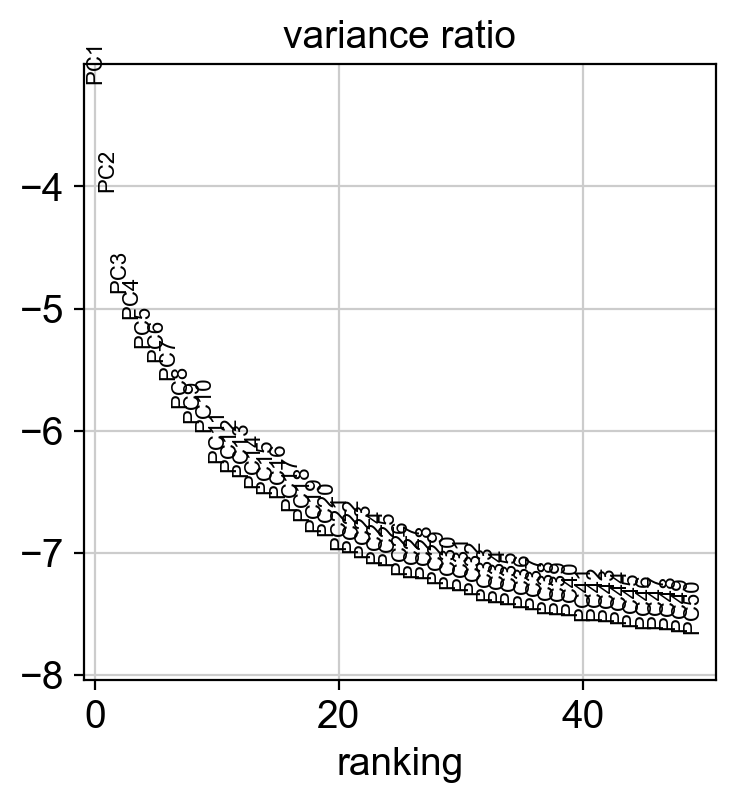

In [29]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### Computing the neighborhood graph

In [29]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Embedding the neighborhood graph

In [30]:
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [31]:
# Code needs to be changed to accomadate the rare case
# when the number of cells is reduced after filtering genes in bdata
bdata.obsm = adata.obsm.copy()
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_pca', 'X_umap'

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


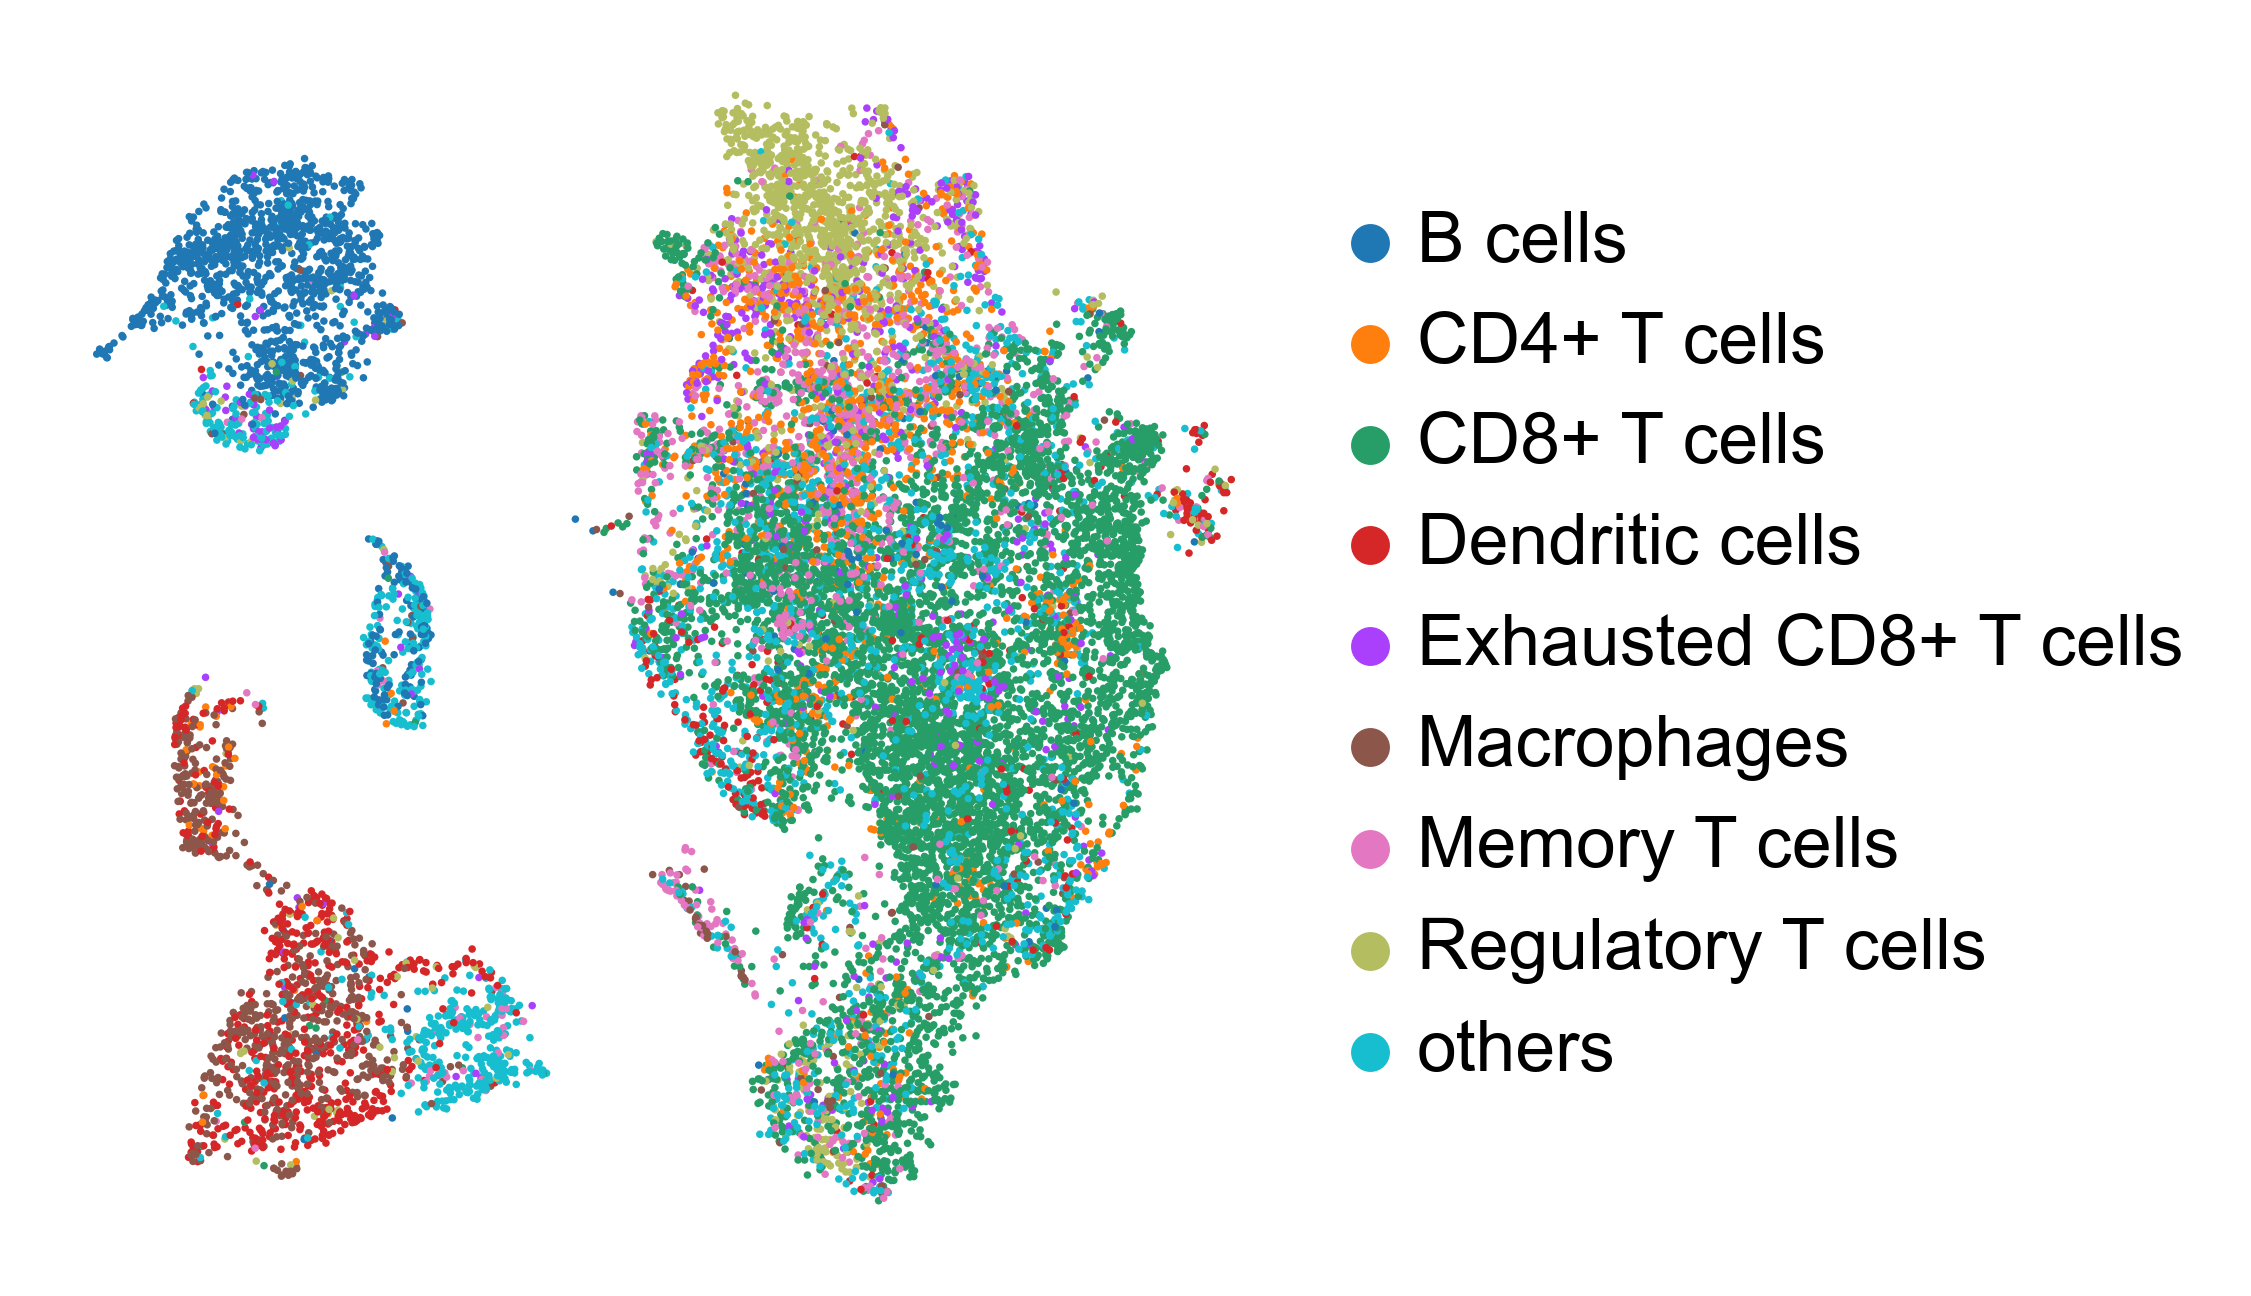

In [35]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(
    bdata,
    color=["cell_type"],
    frameon=False,
    ncols=1, 
    title=''
)

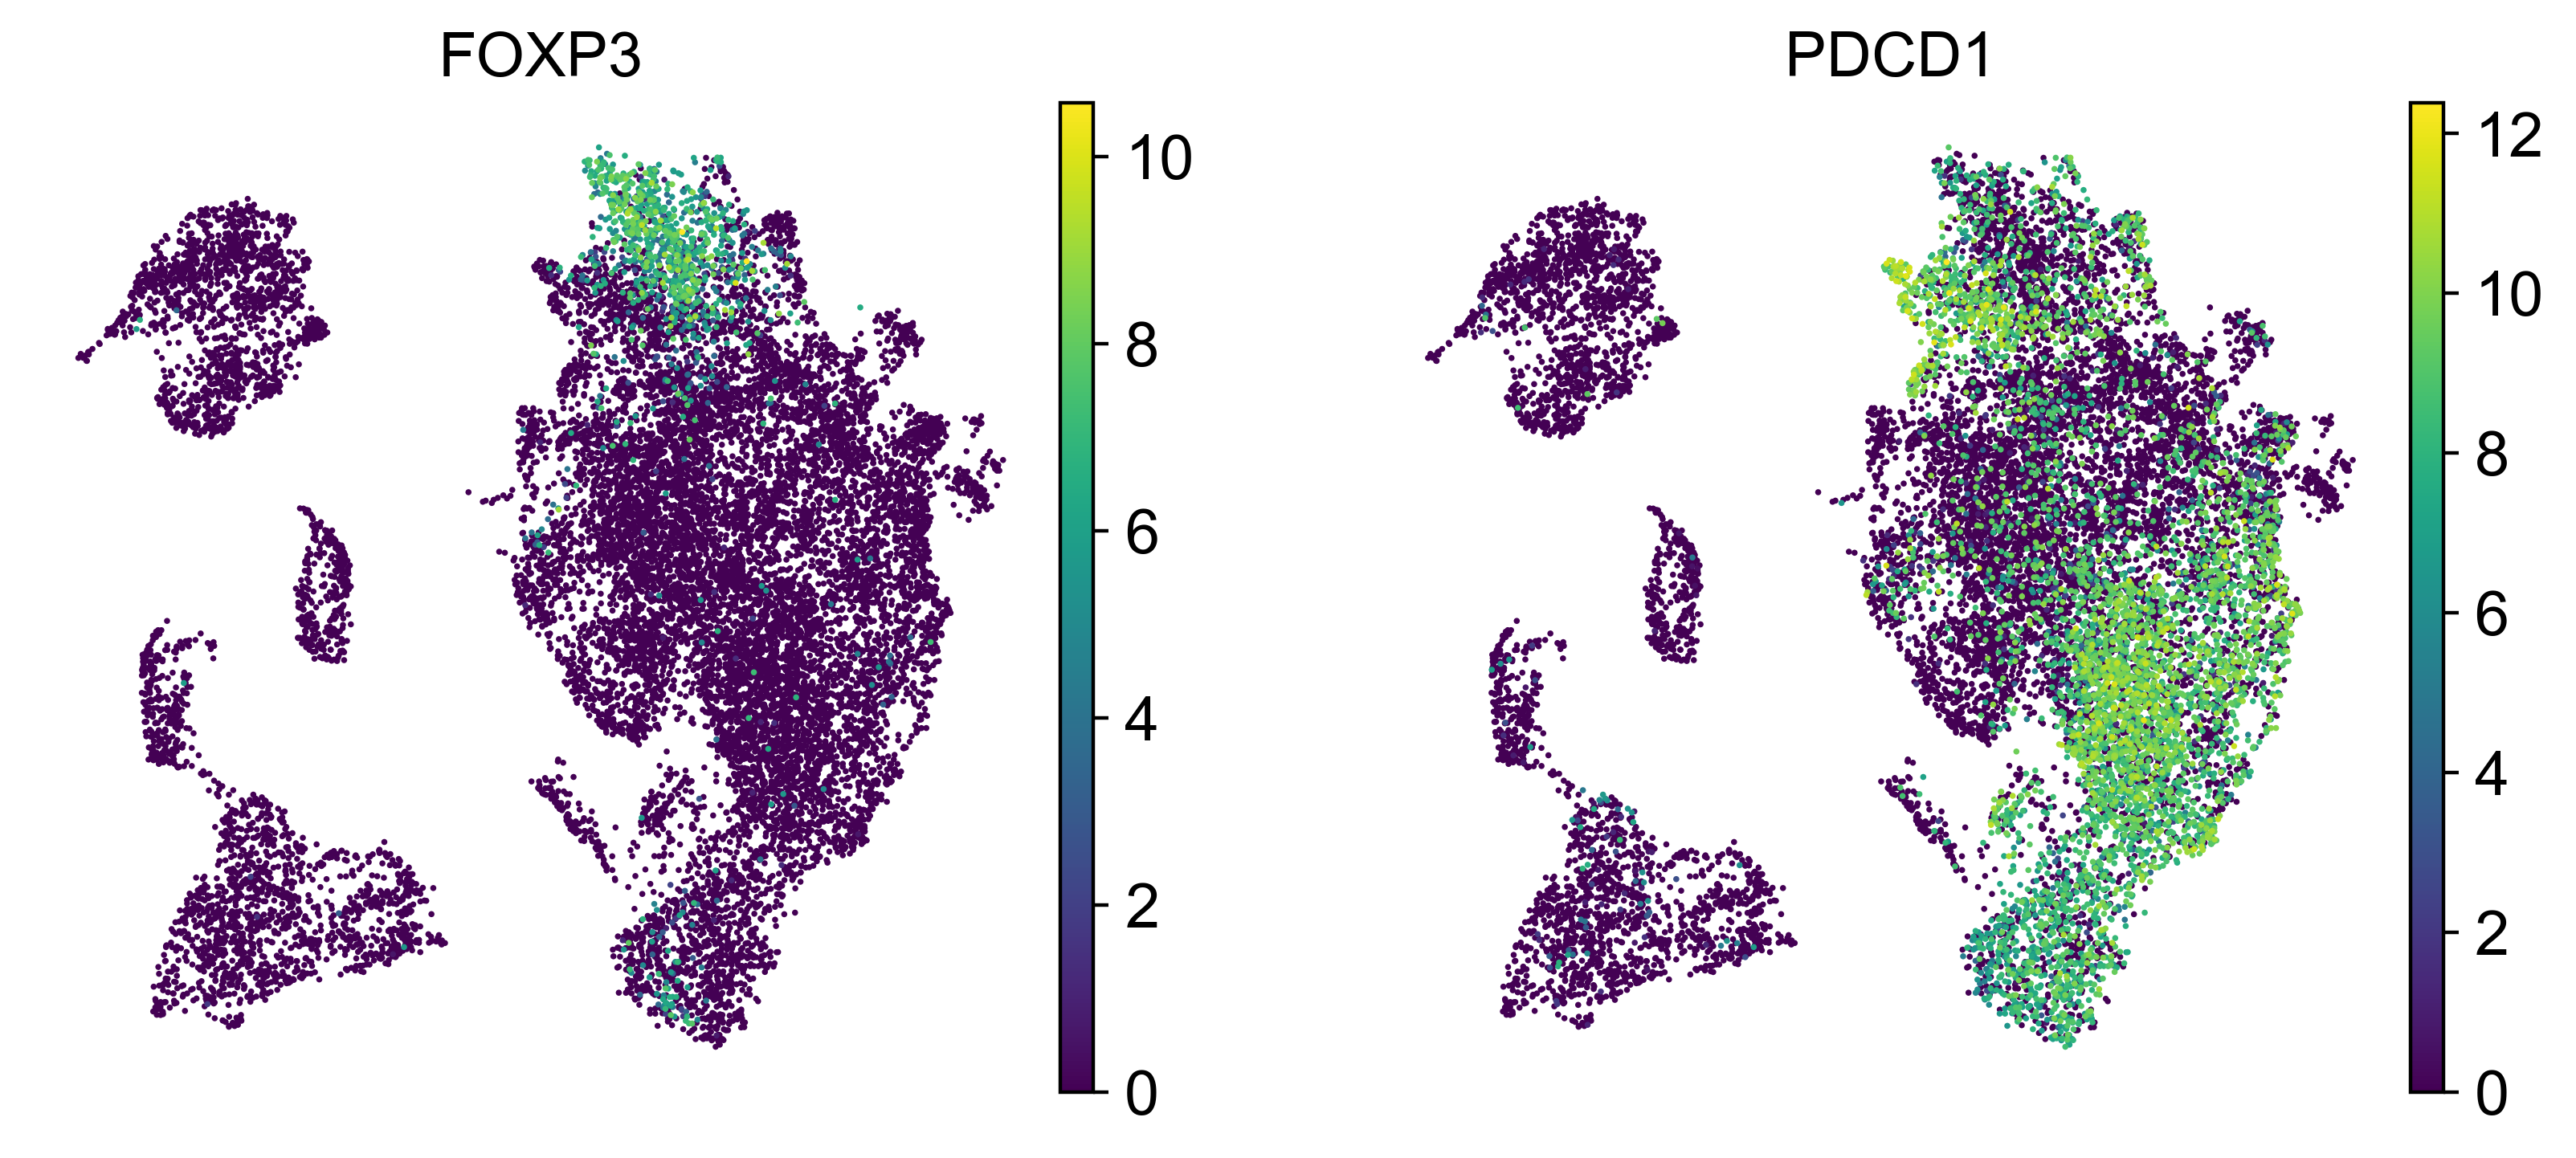

In [40]:
sc.pl.umap(bdata, 
           color=['FOXP3', 'PDCD1'], 
           frameon=False)

In [49]:
sc.tl.rank_genes_groups(bdata, 
                        'cell_type', 
                         method='wilcoxon')
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [51]:
bdata.uns['rank_genes_groups']

{'params': {'groupby': 'cell_type',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MS4A1', 'CD4', 'CD8A', 'ITGAX', 'BTLA', 'CD68', 'LEF1', 'FOXP3', 'THBD'),
            ('CD19', 'PDCD1', 'CD8B', 'CD68', 'PDCD1', 'CD74', 'TCF7', 'IL2RA', 'CD68'),
            ('CD74', 'CXCR3', 'PDCD1', 'THBD', 'CD4', 'ITGAX', 'CD4', 'CD4', 'ITGAX'),
            ('BTLA', 'TCF7', 'CXCR3', 'CD74', 'TCF7', 'CD4', 'BTLA', 'CXCR3', 'IL2RA'),
            ('IL2RA', 'THBD', 'TCF7', 'CD4', 'CXCR3', 'THBD', 'THBD', 'LEF1', 'CD19'),
            ('THBD', 'FOXP3', 'BTLA', 'IL2RA', 'LEF1', 'CXCR3', 'CXCR3', 'BTLA', 'MS4A1'),
            ('FOXP3', 'LEF1', 'LEF1', 'BTLA', 'CD19', 'BTLA', 'FOXP3', 'THBD', 'CD74'),
            ('CD68', 'BTLA', 'THBD', 'FOXP3', 'MS4A1', 'FOXP3', 'IL2RA', 'PDCD1', 'FOXP3'),
            ('LEF1', 'CD19', 'ITGAX', 'CD19', 'THBD', 'IL2RA', 'CD19', 'CD19', 'TCF7'),
            ('ITGAX', 'IL2RA', 'F

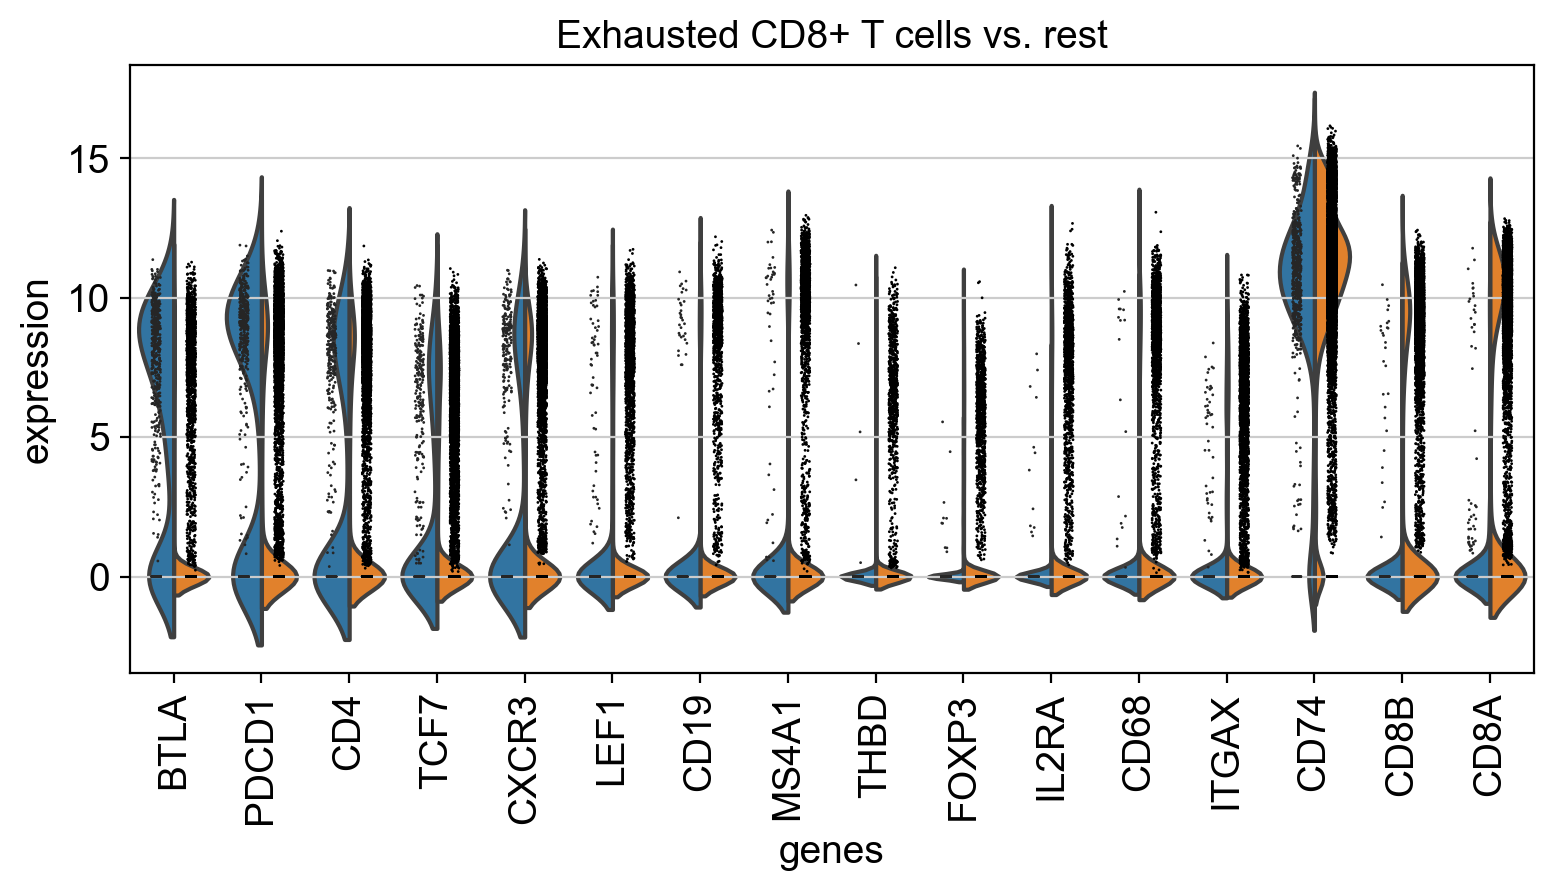

In [69]:
plt.figure(figsize=(9, 4), dpi=100)
sc.pl.rank_genes_groups_violin(bdata, 
                               groups=['Exhausted CD8+ T cells'],
                               n_genes=19)

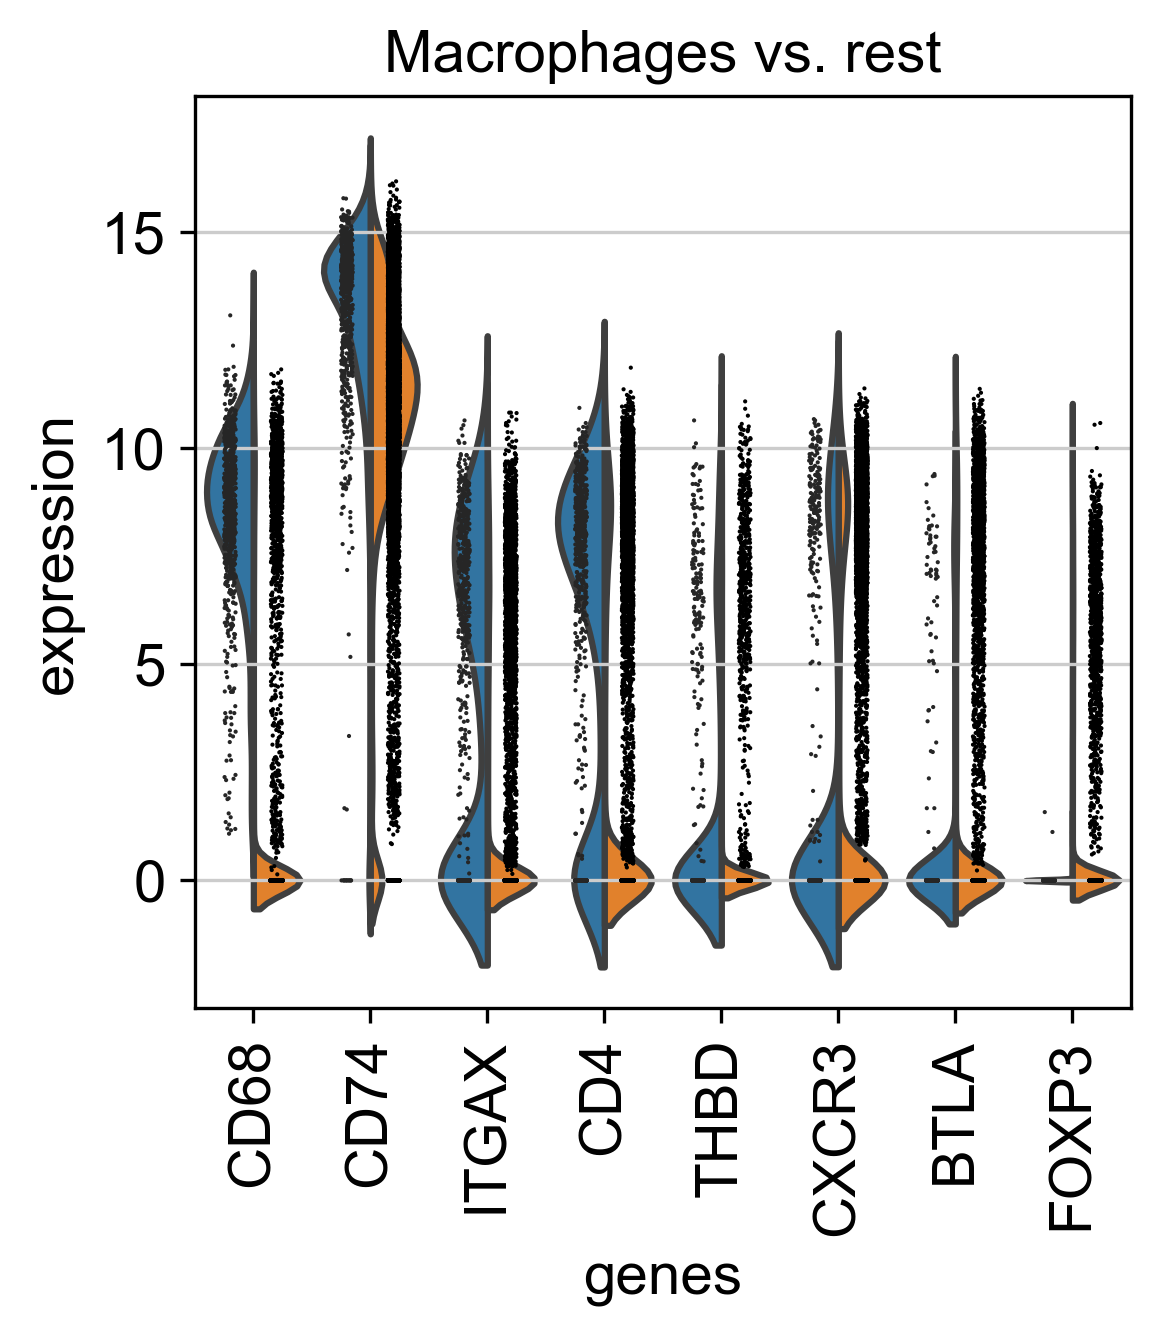

In [55]:
sc.settings.set_figure_params(dpi=150)
sc.pl.rank_genes_groups_violin(bdata, 
                               groups='Macrophages',
                               n_genes=8)

**Change "others" to "Other lymphocytes"**

In [36]:
# sc.settings.set_figure_params(dpi=200)
# sc.pl.umap(bdata, color='cell_type', legend_loc='on data', 
#            title='', legend_fontsize=5)

In [37]:
################################################

In [38]:
################################################
# The following is as if leiden is used for clustering.

### Clustering the neighborhood graph

In [37]:
sc.tl.leiden(adata, resolution=0.25)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

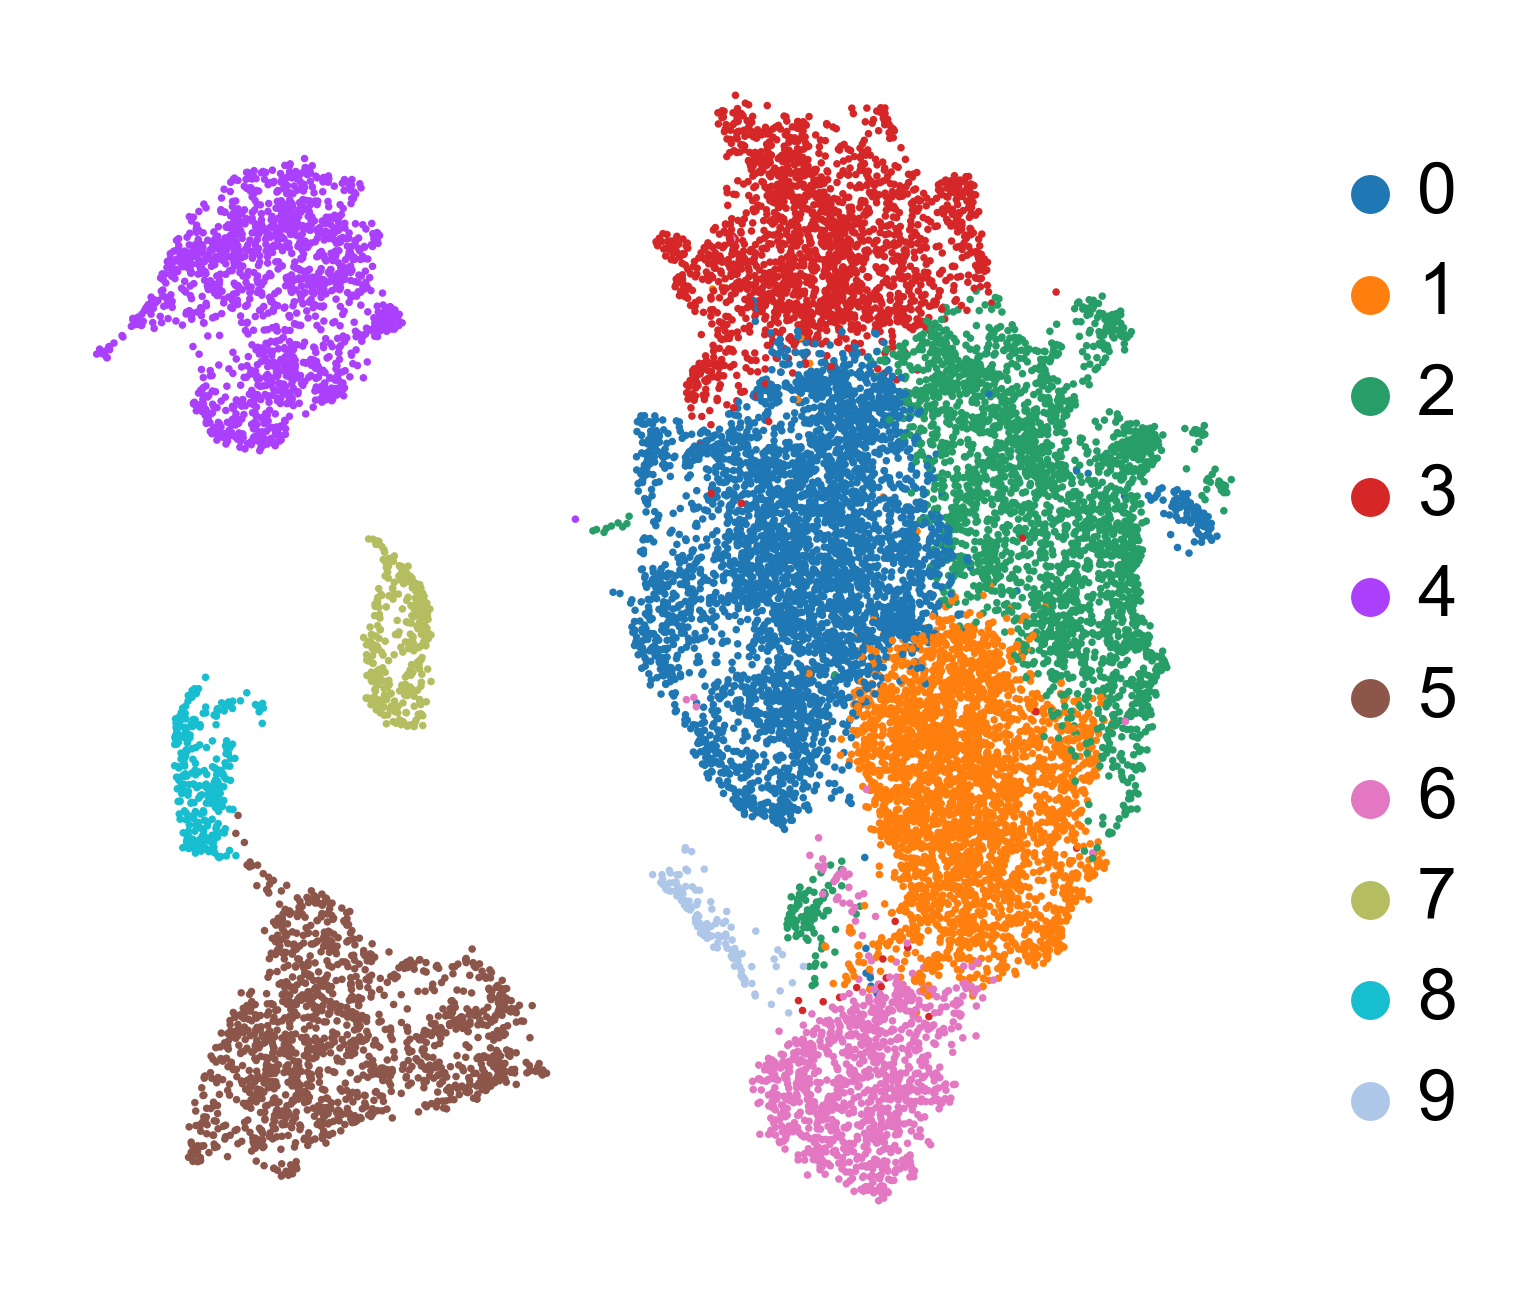

In [39]:
sc.pl.umap(adata, 
           color=['leiden'], 
           frameon=False, 
           title='')

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

In [57]:
# sc.pl.rank_genes_groups_violin(adata)

In [56]:
adata.obs['cell_type'] = bdata.obs['cell_type'].copy()
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [58]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon')
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

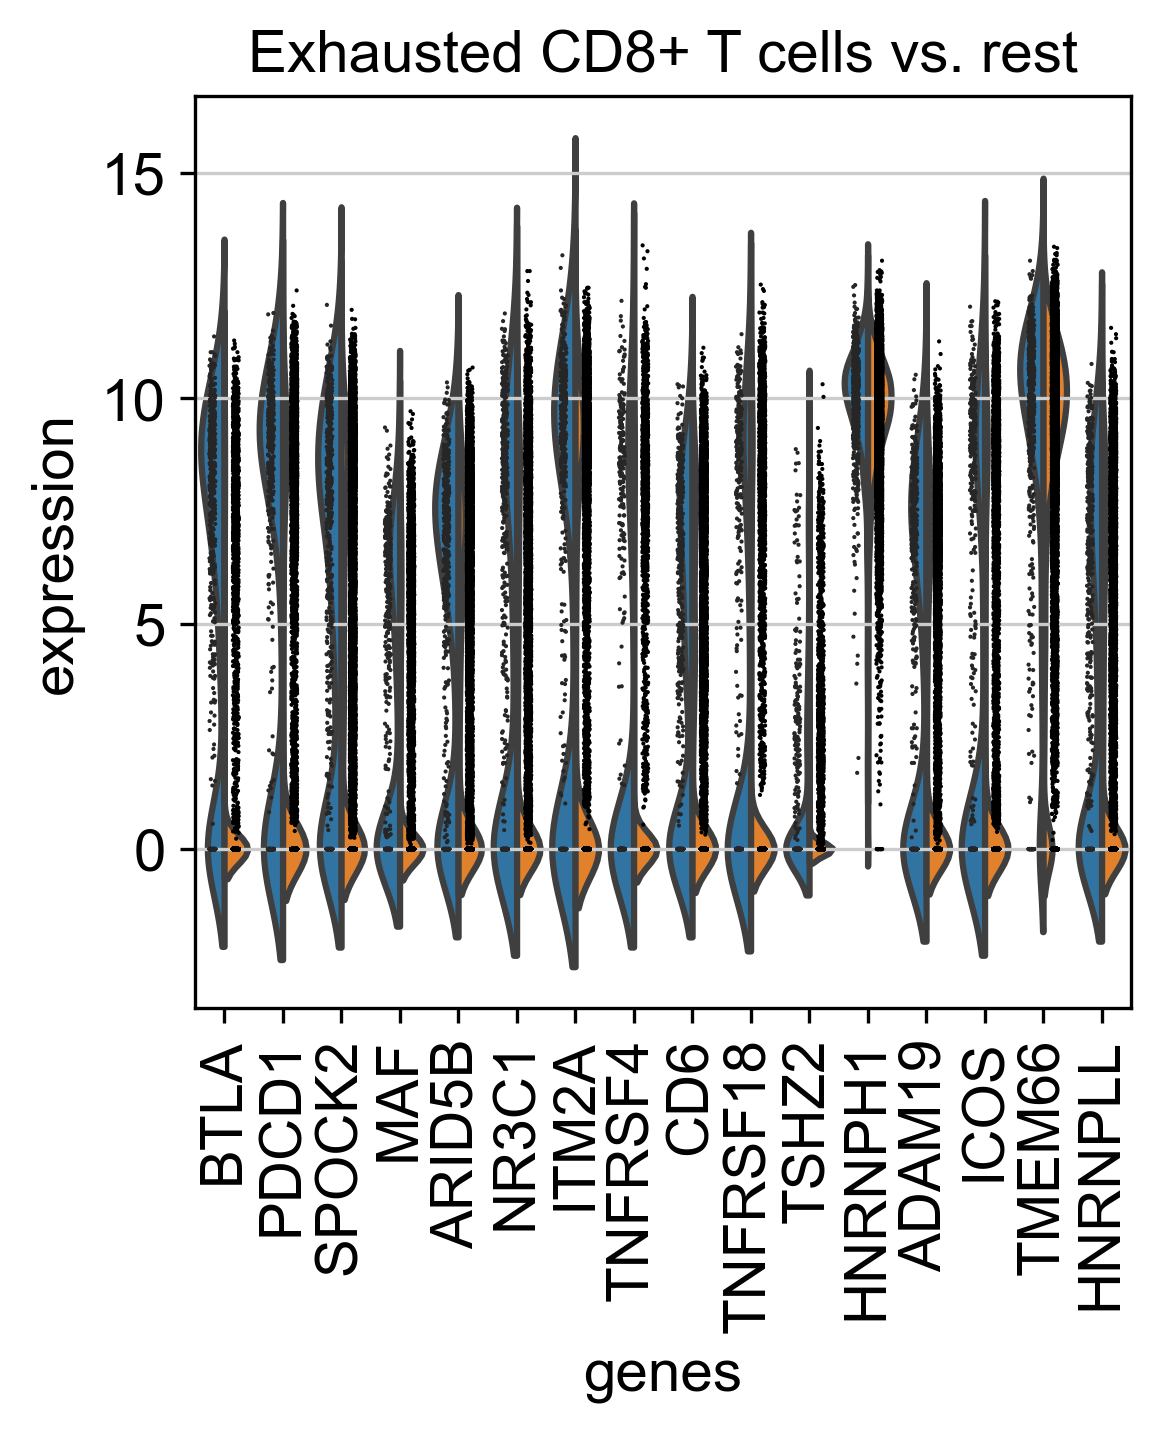

In [62]:
sc.settings.set_figure_params(dpi=150)
sc.pl.rank_genes_groups_violin(adata,
                               groups='Exhausted CD8+ T cells',
                               n_genes=16)

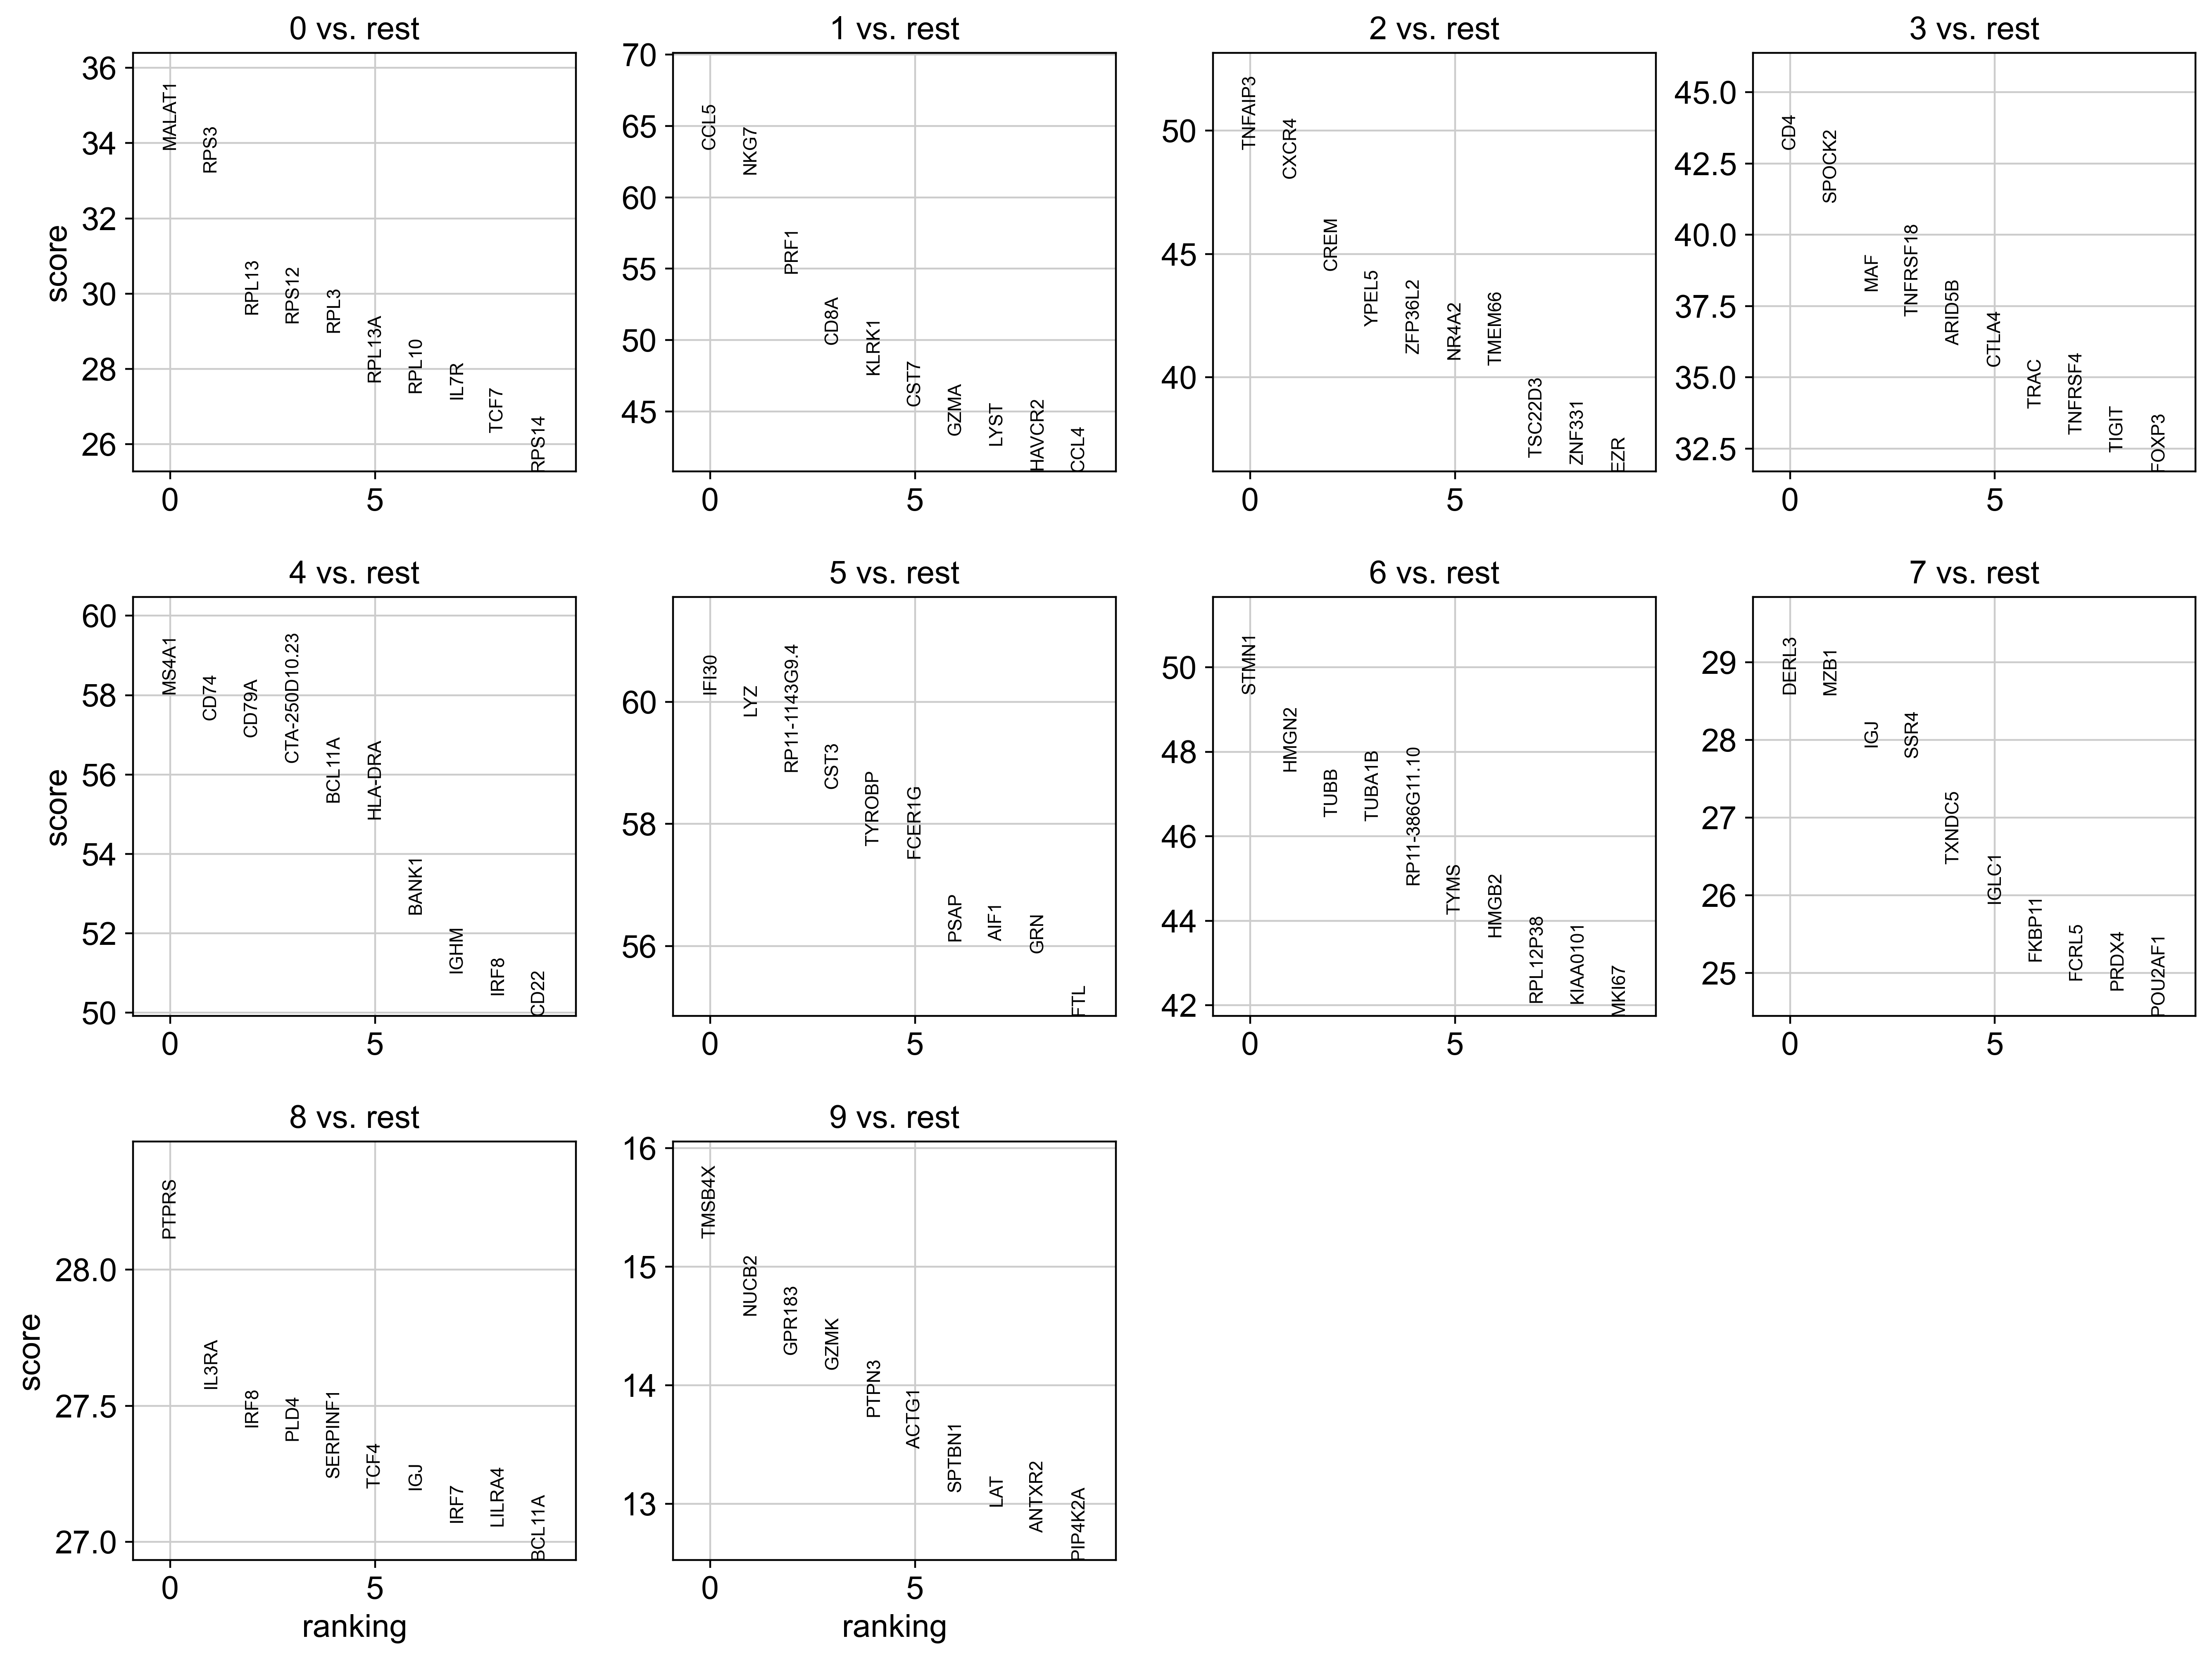

In [42]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1        2         3              4              5  \
0  MALAT1    CCL5  TNFAIP3       CD4          MS4A1          IFI30   
1    RPS3    NKG7    CXCR4    SPOCK2           CD74            LYZ   
2   RPL13    PRF1     CREM       MAF          CD79A  RP11-1143G9.4   
3   RPS12    CD8A    YPEL5  TNFRSF18  CTA-250D10.23           CST3   
4    RPL3   KLRK1  ZFP36L2    ARID5B         BCL11A         TYROBP   
5  RPL13A    CST7    NR4A2     CTLA4        HLA-DRA         FCER1G   
6   RPL10    GZMA   TMEM66      TRAC          BANK1           PSAP   
7    IL7R    LYST  TSC22D3   TNFRSF4           IGHM           AIF1   
8    TCF7  HAVCR2   ZNF331     TIGIT           IRF8            GRN   
9   RPS14    CCL4      EZR     FOXP3           CD22            FTL   

                6        7         8        9  
0           STMN1    DERL3     PTPRS   TMSB4X  
1           HMGN2     MZB1     IL3RA    NUCB2  
2            TUBB      IGJ      IRF8   GPR183  
3          TUBA1B     SSR4      PLD4     GZMK  
4  RP11-386G11.10   TXNDC5  SERPINF1    PTPN3  
5            TYMS    IGLC1      TCF4    ACTG1  
6           HMGB2   FKBP11       IGJ   SPTBN1  
7        RPL12P38    FCRL5      IRF7      LAT  
8        KIAA0101    PRDX4    LILRA4   ANTXR2  
9           MKI67  POU2AF1    BCL11A  PIP4K2A

- 2 B cell clusters (G1- B cells; G2- plasma cells), 
- 2 myeloid clusters (G3- monocytes and/or macrophages; G4- dendritic cells) 
- 7 clusters enriched for T/NK/NKT cells (G5–11)

In [44]:
# set() removes duplicate; then list() converts back to a list
# marker_genes = list(set(['IGHD', 'CD19', 'CD22', # B-cells
#                          'SDC1', 'IGLV6-57', # Plasma cells
#                          'MARCO', 'CD300E', # Monocytes/Macrophages
#                          'PTCRA', 'CLEC4C', # Dendritic cells
#                          'LMNA', 'IL7R', # Lymphocytes
#                          'CD8A', 'CD8B', # Exhausted CD8+ T-cells
#                          'FOXP3', 'CD4', # Regulatory T-cells
#                          'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
#                          'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
#                          'LEF1', 'IL7R', # Memory T-cells
#                          'SPC25', 'CDCA5' # Exhausted lymphocytes
# #                 'CD3E', 'CD2', # T cells
# #                 'CD4', 'CD3E', # CD4 T cells
# #                 'CD8A', 'CD8B', # CD8 T cells
# #                 'FOXP3', 'CD3E', 'CTLA4', 'IL2RA' # Regulatory T cells
# #                 'FOXP3', 'CD3E', 'CD4', # Regulatory CD4 T cells
# #                 'FOXP3', 'CD3E', 'CD8A', 'CD8B'# Regulatory CD8 T cells
# #                 'FOXP3', 'CD3E', 'CD4', 'CD8A', 'CD8B'# Regulatory CD4/CD8 T cells
# #                 'CD3E', 'NCR1', 'NCAMa', # NKT cells
# #                 'FCGR3A', # NK cells
# #                 'CD3E', 'CD2', 'CD28' # Activated T cells
#                ]))
marker_genes = list(OrderedDict.fromkeys(['IGHD', 'CD19', 'CD22', # B-cells
                         'SDC1', 'HID1', # Plasma cells
                         'MARCO', 'CD300E', # Monocytes/Macrophages
                         'PTCRA', 'CLEC4C', # Dendritic cells
                         'IL7R', # Lymphocytes
                         'CD8A', 'CD8B', # Exhausted CD8+ T-cells
                         'FOXP3', 'CD4', # Regulatory T-cells
                         'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
                         'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
                         'LEF1', 'IL7R', # Memory T-cells
                         'SPC25', 'CDCA5' # Exhausted lymphocytes
                                         ]))
marker_genes

['IGHD',
 'CD19',
 'CD22',
 'SDC1',
 'HID1',
 'MARCO',
 'CD300E',
 'PTCRA',
 'CLEC4C',
 'IL7R',
 'CD8A',
 'CD8B',
 'FOXP3',
 'CD4',
 'FGFBP2',
 'TGFBR3',
 'VCAM1',
 'CTLA4',
 'LEF1',
 'SPC25',
 'CDCA5']

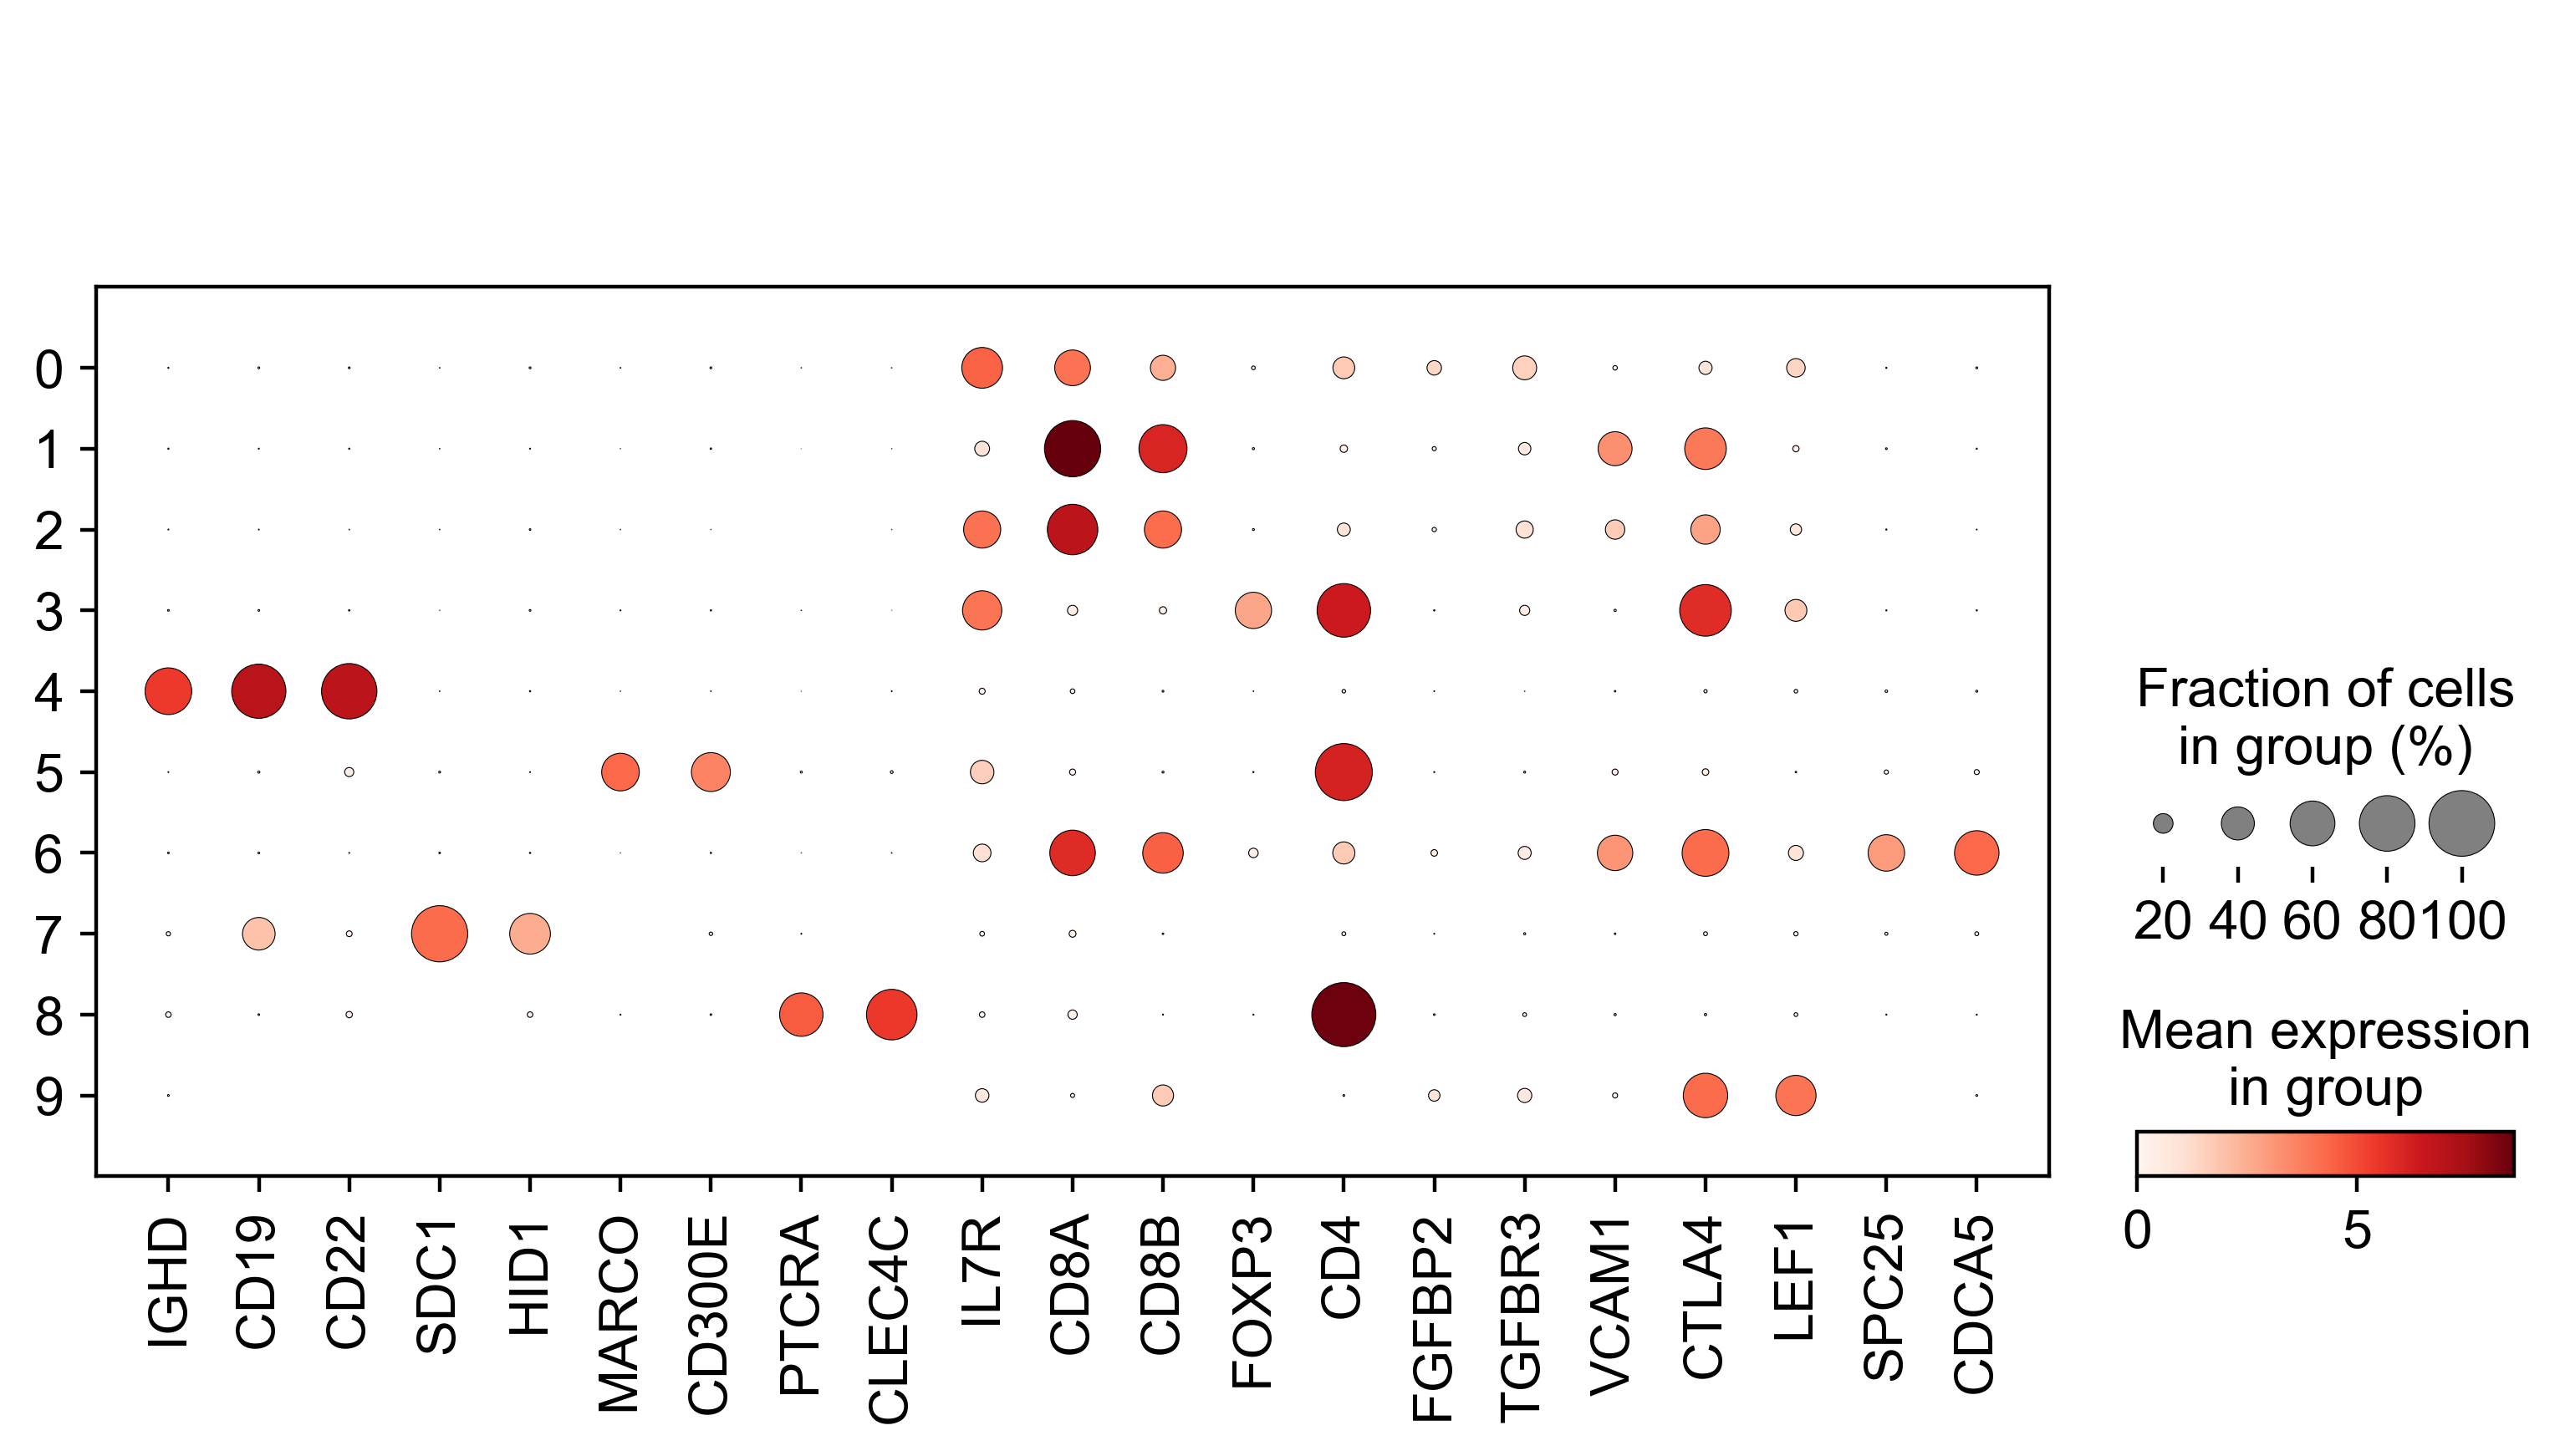

In [45]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

00 

01 

02

03 

04 B-cells

05 Monocytes/Macrophages

06

07 Plasma cells

08 Dendritic cells

09

10